In [616]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [617]:
def load_pair(tissue_num, samp_num, kind="salmon_all_default"):
    meth = kind.split('_')[0]
    if meth == 'salmon':
        qf = 'quant.sf'
        nk = 'Name'
        rename_fun = lambda x : x
    elif meth == 'kallisto':
        qf = 'abundance.tsv'
        nk = 'Name'
        rename_fun = lambda x : x.rename(columns={'target_id': 'Name', 'est_counts' : 'NumReads', 'tpm' : 'TPM'})
    else:
        print("unknown method {}".format(meth))
        
    p = pd.read_csv("../quants/tissue{}/sample{}/{}/{}".format(tissue_num, samp_num, kind, qf), sep="\t")
    p = rename_fun(p)
    t = pd.read_csv("../simulated_reads/tissue{}/sample{}/all_true_counts.tsv".format(tissue_num, samp_num), sep="\t")
    j = pd.merge(t, p, left_on='tname', right_on=nk, how="outer").fillna(0.0)
    return j

In [618]:
def load_quant(tissue_num, samp_num, kind="salmon_all_default"):
    meth = kind.split('_')[0]
    if meth == 'salmon':
        qf = 'quant.sf'
        nk = 'Name'
        rename_fun = lambda x : x
    elif meth == 'kallisto':
        qf = 'abundance.tsv'
        nk = 'Name'
        rename_fun = lambda x : x.rename(columns={'target_id': 'Name', 'est_counts' : 'NumReads', 'tpm' : 'TPM'})
    else:
        print("unknown method {}".format(meth))
        
    p = pd.read_csv("../quants/tissue{}/sample{}/{}/{}".format(tissue_num, samp_num, kind, qf), sep="\t")
    p = rename_fun(p)
    return p

In [703]:
def get_fp_fn(j, thresh=np.finfo(float).eps):
    jc = j.copy()
    jc = jc.loc[(jc['Name'].str.startswith('CHS')) | (jc['tname'].str.startswith('CHS')), :]
    jc.loc[(jc['NumReads'] <= thresh), 'NumReads'] = 0.

    fn = jc.loc[ (jc['true_count'] > 0 )  & (jc['NumReads'] == 0)].shape[0]
    fp = jc.loc[ (jc['true_count'] == 0 ) & (jc['NumReads'] > 0)].shape[0]
    tp = jc.loc[ (jc['true_count'] > 0 )  & (jc['NumReads'] > 0)].shape[0]
    tn = jc.loc[ (jc['true_count'] == 0 ) & (jc['NumReads'] == 0)].shape[0]
    return (fp, fn, tp, tn)

In [620]:
def clean_names(df):
    df = df.replace('salmon_all_default', 'salmon (all)')
    df = df.replace('salmon_real_default', 'salmon (real)')

    df = df.replace('salmon_all_em', 'salmon-em (all)')
    df = df.replace('salmon_real_em', 'salmon-em (real)')

    df = df.replace('salmon_all_nodecoy_default', 'salmon-reduced (all)')
    df = df.replace('salmon_real_nodecoy_default', 'salmon-reduced (real)')

    df = df.replace('salmon_all_nodecoy_em', 'salmon-reduced-em (all)')
    df = df.replace('salmon_real_nodecoy_em', 'salmon-reduced-em (real)')

    df = df.replace('kallisto_all_default', 'kallisto (all)')
    df = df.replace('kallisto_real_default', 'kallisto (real)')

    df = df.replace('kallisto_all_stranded_default', 'kallisto-stranded (all)')
    df = df.replace('kallisto_real_stranded_default', 'kallisto-stranded (real)')
    return df

In [621]:
def get_f1(fp, fn, tp, tn):
    return tp / (tp + 0.5 * (fp + fn))

In [708]:
def compute_metrics(j, pcount=0.1):
    #j = load_pair(t, s, mn)
    jp = j.loc[ (j['Name'].str.startswith('CHS') | (j['tname'].str.startswith('CHS'))), :].copy()

    sp_corr = jp[['true_count', 'NumReads']].corr(method='spearman').iloc[0,1]

    log_pear_corr = np.log2(jp[['true_count', 'NumReads']]+pcount).corr().iloc[0,1]
    
    fp, fn, tp, tn = get_fp_fn(jp)

    f1 = get_f1(fp, fn, tp, tn)
    
    rd = (jp['true_count'] - jp['NumReads']) / (jp['true_count'] + jp['NumReads'])
    
    # a zero denominator implies zero numerator, no error
    rd[rd.isna()] = 0.
    mard = rd.abs().mean()
    med_ard = rd.abs().median()
    
    return {'spearman' : sp_corr, 'log_pearson' : log_pear_corr, \
            'fp' : fp, 'fn' : fn, 'tp' : tp, 'tn' : tn, 'f1' : f1, \
            'mard' : mard}

In [622]:
sns.set_theme(context='paper', style='white', palette=sns.color_palette('nipy_spectral'))

In [623]:
method_list = [('salmon', 'salmon_all_default'), ('salmon', 'salmon_all_em'), \
               ('salmon', 'salmon_all_nodecoy_default'), \
               ('salmon', 'salmon_all_nodecoy_em'), ('salmon', 'salmon_real_nodecoy_em'), \
               ('salmon', 'salmon_real_default'), ('salmon', 'salmon_real_em'), \
               ('salmon', 'salmon_real_nodecoy_default'), \
               ('kallisto', 'kallisto_all_default'), ('kallisto', 'kallisto_all_stranded_default'), \
               ('kallisto', 'kallisto_real_default'), ('kallisto', 'kallisto_real_stranded_default')]

In [624]:
label_order = ['salmon (all)', 'salmon (real)', 'salmon-em (all)', 'salmon-em (real)',
               'salmon-reduced (all)', 'salmon-reduced (real)', 'salmon-reduced-em (all)',
               'salmon-reduced-em (real)', 'kallisto (all)', 'kallisto (real)', 
               'kallisto-stranded (all)', 'kallisto-stranded (real)']

In [625]:
def get_corrs():
    dat = []
    for t in range(3):
        for s in range(10):
            print(t,s)
            for p, m in method_list:
                j = load_pair(t, s, "{}".format(m))
                # subset to only (but all) annotated transcripts
                j = j.loc[(j['Name'].str.startswith('CHS')) | (j['tname'].str.startswith('CHS')), :]
                z = j[['true_count', 'NumReads']].corr(method='spearman').iloc[0,1]
                #ty = m.split('_')[1]
                #m2 = m.replace('_{}_'.format(ty), '_')
                dat.append((m, z))
    return clean_names(pd.DataFrame(dat, columns=['method', 'value']))

In [709]:
def get_metrics(thresh=np.finfo(float).eps):
    dat_s = []
    for t in range(3):
        print("tissue {}".format(t))
        for s in range(10):
            for m, mn in method_list:# ['salmon', 'kallisto']:
                j = load_pair(t, s, mn)
                metrics = compute_metrics(j)
                for k,v in metrics.items():
                    dat_s.append( (k, mn, v) )
    return clean_names(pd.DataFrame(dat_s, columns=['measure', 'method', 'value']))

In [733]:
def plot_f1(ds2, psuffix=""):
    with sns.plotting_context("paper", font_scale=1.5):
        plt.figure(figsize=(8,7))
        ax = sns.swarmplot(data=ds2.loc[ds2.measure.str.contains('f1'), :], x='method', y='value', hue='method',\
                            palette='nipy_spectral', order=label_order, size=3)

        ax.annotate('salmon', xy=(2.7,0.42), xytext=(2.7,0.42))
        ax.annotate("", xy=(-0.5, 0.42), xytext=(2.5,0.42),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        ax.annotate("", xy=(7.0, 0.42), xytext=(4.0,0.42),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))

        ax.annotate('kallisto', xy=(8.8, 0.42), xytext=(8.8, 0.42))
        ax.annotate("", xy=(7.5, 0.42), xytext=(8.6,0.42),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        ax.annotate("", xy=(10.0, 0.42), xytext=(11.5,0.42),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))

        plt.gca().get_legend().remove()
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("")
        plt.ylabel(r'$F_1$ score')
        sns.despine()
        plt.savefig('../figures/f1_{}.pdf'.format(psuffix), bbox_inches="tight")

In [785]:
def plot_fp_fn(ds, psuffix=""):
    with sns.plotting_context("paper", font_scale=1.5):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), 
                                 gridspec_kw=dict(height_ratios=(1, 1), hspace=0.2))
        sns.swarmplot(data=ds.loc[ds.measure.str.contains('fp'), :], size=3, x='method', y='value', hue='method',\
                       palette='nipy_spectral', order=label_order, ax=axes[0])

        axes[0].set_ylabel('# false positives')
        axes[0].get_legend().remove()
        axes[0].set_xticks([])
        axes[0].set_xlabel('')

        sns.swarmplot(data=ds.loc[ds.measure.str.contains('fn'), :], size=3, x='method', y='value', hue='method',\
                       palette='nipy_spectral',  order=label_order, ax=axes[1])
        axes[1].get_legend().remove()
        axes[1].set_ylabel('# false negatives')
        
        plt.xticks(rotation=45, ha='right')

        axes[0].annotate('salmon', xy=(3,1000), xytext=(3,1000), textcoords='data', xycoords='data', annotation_clip=False)#, bbox=dict(boxstyle ="round", fc ="0.8"))
        axes[0].annotate("", xy=(-0.5,200), xytext=(7.5,200),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'),
                    annotation_clip=False)
        axes[0].annotate('kallisto', xy=(9,1000), xytext=(9,1000), textcoords='data', xycoords='data', annotation_clip=False)#, bbox=dict(boxstyle ="round", fc ="0.8"))
        axes[0].annotate("", xy=(7.75,200), xytext=(11.5,200),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'),
                    annotation_clip=False)

        axes[1].set_xlabel('')
        sns.despine()
        plt.savefig('../figures/fp_fn_{}.pdf'.format(psuffix), bbox_inches="tight")

In [711]:
def plot_corr_sp(ds):
    corr_df = ds.loc[ds.measure.str.contains('spearman'), :]
    with sns.plotting_context("paper", font_scale=1.5):
        plt.figure(figsize=(8,6))
        ax = sns.swarmplot(data=corr_df, x='method', y='value',palette='nipy_spectral', dodge=True, size=3,
                          order=['salmon (all)', 'salmon (real)', 'salmon-em (all)', 'salmon-em (real)',
                                 'salmon-reduced (all)', 'salmon-reduced (real)', 'salmon-reduced-em (all)',
                                 'salmon-reduced-em (real)', 'kallisto (all)', 'kallisto (real)', 
                                 'kallisto-stranded (all)', 'kallisto-stranded (real)'])


        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Spearman correlation')
        plt.xlabel('')

        ax.annotate('salmon', xy=(2.5,0.49), xytext=(2.5,0.49))
        ax.annotate("", xy=(-0.5, 0.49), xytext=(2.5,0.49),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        ax.annotate("", xy=(7.0, 0.49), xytext=(3.8,0.49),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))

        ax.annotate('kallisto', xy=(8.6,0.49), xytext=(8.6,0.49))
        ax.annotate("", xy=(7.5, 0.49), xytext=(8.5,0.49),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        ax.annotate("", xy=(10.0, 0.49), xytext=(11.5,0.49),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        sns.despine()
        plt.savefig('../figures/spearman.pdf', bbox_inches="tight")

In [731]:
def plot_corr_log_pear(ds):
    corr_df = ds.loc[ds.measure.str.contains('log_pearson'), :]
    with sns.plotting_context("paper", font_scale=1.5):
        plt.figure(figsize=(8,6))
        ax = sns.swarmplot(data=corr_df, x='method', y='value',palette='nipy_spectral', dodge=True, size=3,
                          order=['salmon (all)', 'salmon (real)', 'salmon-em (all)', 'salmon-em (real)',
                                 'salmon-reduced (all)', 'salmon-reduced (real)', 'salmon-reduced-em (all)',
                                 'salmon-reduced-em (real)', 'kallisto (all)', 'kallisto (real)', 
                                 'kallisto-stranded (all)', 'kallisto-stranded (real)'])


        plt.xticks(rotation=45, ha='right')
        plt.ylabel('log2 Pearson correlation')
        plt.xlabel('')

        by = 0.56
        ax.annotate('salmon', xy=(2.5, by), xytext=(2.5, by))
        ax.annotate("", xy=(-0.5, by), xytext=(2.5, by),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        ax.annotate("", xy=(7.0, by), xytext=(3.8, by),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))

        ax.annotate('kallisto', xy=(8.6, by), xytext=(8.6, by))
        ax.annotate("", xy=(7.5, by), xytext=(8.5, by),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        ax.annotate("", xy=(10.0, by), xytext=(11.5, by),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        sns.despine()
        plt.savefig('../figures/log_pearson.pdf', bbox_inches="tight")

In [725]:
def plot_mard(ds):
    corr_df = ds.loc[ds.measure.str.contains('mard'), :]
    with sns.plotting_context("paper", font_scale=1.5):
        plt.figure(figsize=(8,6))
        ax = sns.swarmplot(data=corr_df, x='method', y='value',palette='nipy_spectral', dodge=True, size=3,
                          order=['salmon (all)', 'salmon (real)', 'salmon-em (all)', 'salmon-em (real)',
                                 'salmon-reduced (all)', 'salmon-reduced (real)', 'salmon-reduced-em (all)',
                                 'salmon-reduced-em (real)', 'kallisto (all)', 'kallisto (real)', 
                                 'kallisto-stranded (all)', 'kallisto-stranded (real)'])
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('MARD')
        plt.xlabel('')
        
        by = 0.04
        ax.annotate('salmon', xy=(2.5, by), xytext=(2.5, by))
        ax.annotate("", xy=(-0.5, by), xytext=(2.5, by),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        ax.annotate("", xy=(7.0, by), xytext=(3.8, by),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))

        ax.annotate('kallisto', xy=(8.6, by), xytext=(8.6, by))
        ax.annotate("", xy=(7.5, by), xytext=(8.5, by),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        ax.annotate("", xy=(10.0, by), xytext=(11.5, by),
                    textcoords='data', xycoords='data',
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3", color='black'))
        sns.despine()
        plt.savefig('../figures/mard.pdf', bbox_inches="tight")

In [630]:
def show_fp_fn(z):
    return z.loc[ (z['method'].str.split(' ').str.get(1) == '(all)') & (z['measure'].isin(['fp', 'fn'])), :].groupby(['method', 'measure']).mean()

In [786]:
def plot_fp_fn_sameaxis(ds, psuffix=""):
    with sns.plotting_context("paper", font_scale=1.5):
        plt.figure(figsize=(10,8))
        subframe = ds.loc[ (ds.measure.str.contains('fp') | ds.measure.str.contains('fn')) , :].copy()
        sns.swarmplot(data=subframe, size=2, x='method', y='value', hue='measure',\
                       palette='nipy_spectral', order=label_order)
        plt.yticks(list(plt.yticks()[0]) + [2000, 5000])
        plt.ylim(bottom=1)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('count')
        plt.xlabel('')
        L = plt.legend(loc=2)
        L.get_texts()[0].set_text('FPs')
        L.get_texts()[1].set_text('FNs')
        sns.despine()

In [710]:
ds = get_metrics()

tissue 0
tissue 1
tissue 2


/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


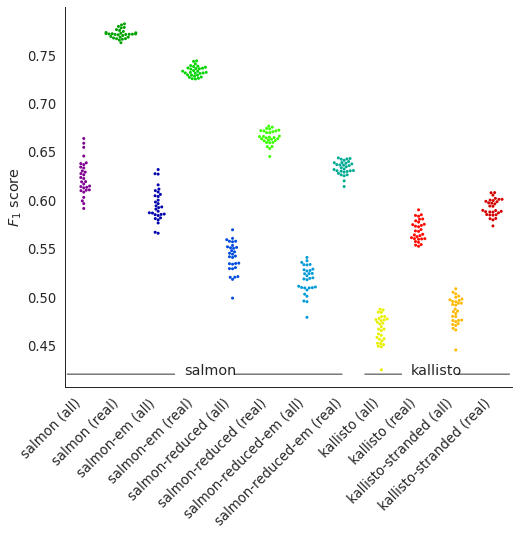

In [734]:
plot_f1(ds)

/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


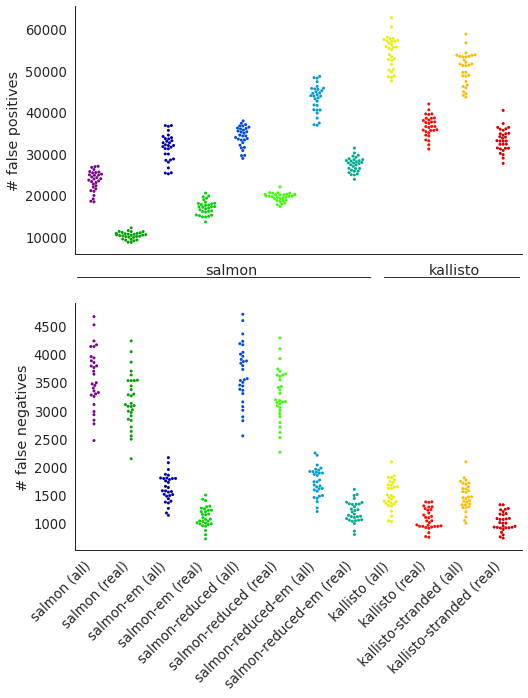

In [787]:
plot_fp_fn(ds)

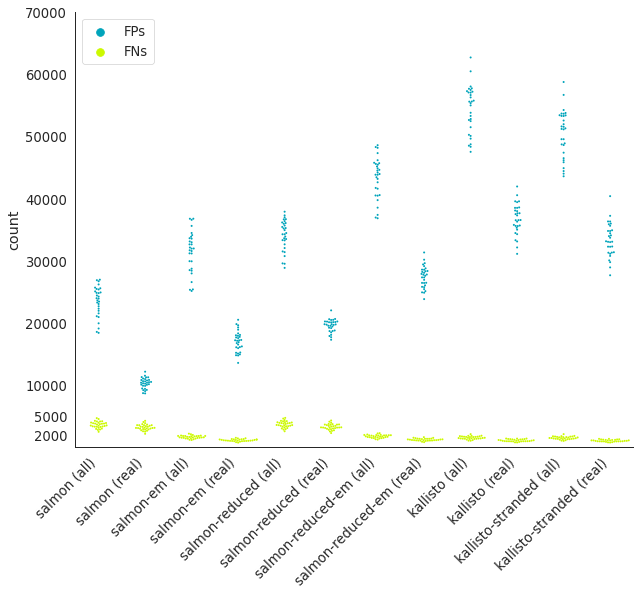

In [788]:
plot_fp_fn_sameaxis(ds)

/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


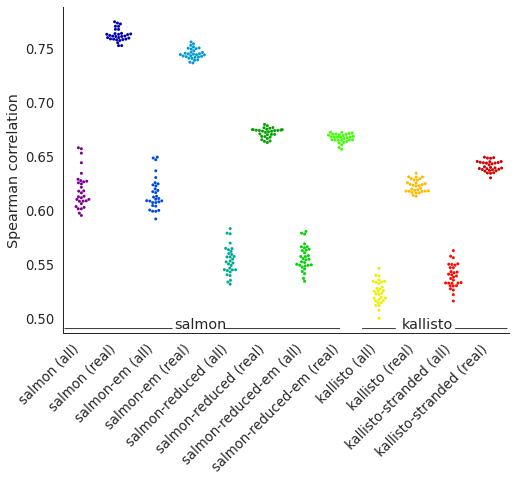

In [720]:
plot_corr_sp(ds)

/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/rob/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


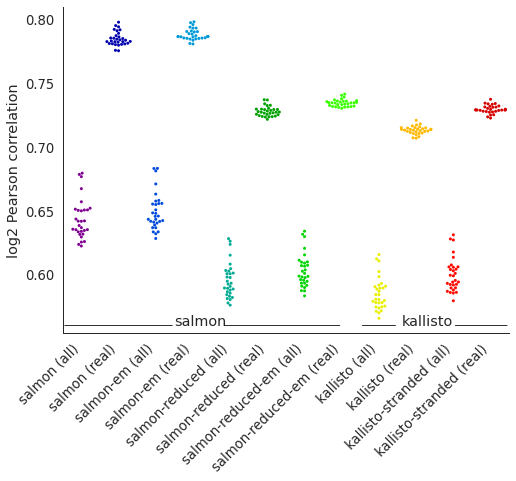

In [732]:
plot_corr_log_pear(ds)

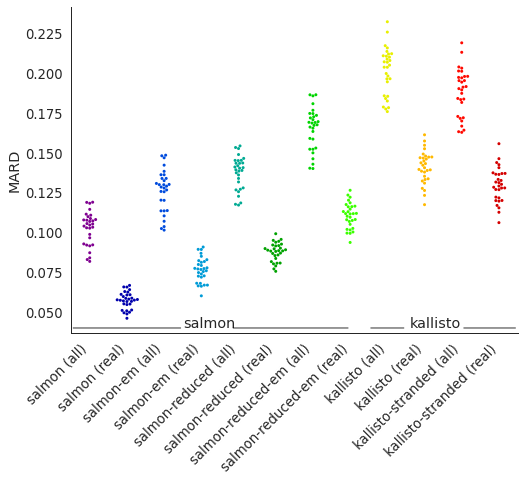

In [726]:
plot_mard(ds)

Show average FP/FN for different methods in "all" and "real" sets

In [789]:
show_fp_fn(ds)

value
method                  measure              
kallisto (all)          fn        1507.066667
                        fp       54426.800000
kallisto-stranded (all) fn        1473.666667
                        fp       50462.500000
salmon (all)            fn        3582.266667
                        fp       23485.700000
salmon-em (all)         fn        1626.200000
                        fp       31470.033333
salmon-reduced (all)    fn        3658.000000
                        fp       34111.566667
salmon-reduced-em (all) fn        1729.766667
                        fp       43321.666667